# Import packages

In [1]:
import pandas as pd
import numpy as np
import parse
import re
import seaborn as sns
from bs4 import BeautifulSoup # handle html strings
from matplotlib import pyplot as plt
from ProcessHTML import ProcessHTML
from ExtractRooms import ExtractRooms
from GeneralizeDataset import GeneralizeDataset

# Read Dataset

In [2]:
filename = "../datasets/PropertyData_wDesc.csv"
# Default encoding (UTF-8) not working on this dataset
data = pd.read_csv(filename, encoding="ISO8859-1")
data.head()

,Postcode,Created,Advertised,Agreed,Completed,Date Listing Last Cancelled,Sale or Let,RTD3308_outside_space1 - Outside Space Description,EweMove Description S1 Features,EweMove Description S2 Description,...,Price / Rent,Price Qualifier,Sale Price % Achieved,Current EPC - EPC Expiry Date,DESC Council Tax Band,DESC Leasehold Ground Rent,DESC Leasehold Service Charge,ZPG_lease_expiry_years_remaining,# of Enquiry or viewings,# of Apps/Offers
0,LU7 4WN,03/04/2019,03/04/2019,NaN,NaN,28/02/2022,Sale,Communal Garden,<ul><li>CASH BUYERS ONLY</li><li>No Upper Chai...,Cash Buyers... You could pounce super quick on...,...,"<font color='blue'>&pound;140,000</font><br>Of...",Offers In Excess Of,130.71%,11/03/2028,Band B,NaN,NaN,68.0,32,12
1,L23 6YD,21/03/2019,24/03/2019,05/04/2021,28/06/2021,26/02/2020,Sale,NaN,<ul><li>Sea Views</li><li>Very Popular Locatio...,WATCHING THE SHIPS ROLL IN - from your very ow...,...,"<font color='blue'>&pound;325,000</font><br>Of...",Offers Over,NaN,28/03/2029,Band E,NaN,NaN,NaN,15,10
2,DA17 5PJ,25/03/2019,03/04/2019,25/01/2021,15/03/2021,13/06/2019,Sale,Rear Garden,<ul><li>Call NOW 24/7 or book instantly online...,"Guide price &pound;325,000 - &pound;350,000.Lo...",...,"<font color='blue'>&pound;325,000</font><br>Gu...",Guide Price,NaN,12/07/2028,Band D,NaN,NaN,NaN,14,4
3,NW4 1AP,28/06/2019,04/07/2019,NaN,NaN,NaN,Sale,NaN,<ul><li>5 bed link detached FREEHOLD house wit...,EweMove Hampstead - A rare opportunity to acqu...,...,"<font color='blue'>&pound;1,095,000</font><br>...",Guide Price,NaN,30/06/2029,NaN,NaN,NaN,NaN,13,1
4,GL7 5UX,12/06/2019,09/08/2019,13/04/2021,05/07/2021,NaN,Sale,Back Garden,<ul><li>Four Bedrooms</li><li>Detached</li><li...,For anyone looking for a family home in South ...,...,"<font color='blue'>&pound;395,000</font><br>",NaN,100.00%,30/06/2024,NaN,NaN,NaN,NaN,11,9


In [3]:
data.shape

(3649, 35)

In [4]:
nan_data = data.isnull().sum()
for i in range(len(nan_data)):
    nan_data.iloc[i] = nan_data.iloc[i] / data.shape[0] * 100
nan_data

Postcode                                               0.000000
Created                                                0.000000
Advertised                                            12.414360
Agreed                                                37.845985
Completed                                             40.641272
Date Listing Last Cancelled                           59.714990
Sale or Let                                            0.000000
RTD3308_outside_space1 - Outside Space Description    39.736914
EweMove Description S1 Features                        0.000000
EweMove Description S2 Description                     8.248835
EweMove Description S3 Rooms                          26.774459
EweMove Description S4 Summary                         0.000000
RTD3307_parking1 - Parking Description                36.475747
RTD3307_parking2 - Parking Description                56.919704
RTD3307_parking3 - Parking Description                76.157851
RTD3308_outside_space2 - Outside Space D

# Handling HTML text

## EweMove Description S1 Features

In [5]:
string = data["EweMove Description S1 Features"][0]
soup = BeautifulSoup(string, "html.parser")

In [6]:
features = soup.select("li")
for feature in features:
    print(feature.string.strip())

CASH BUYERS ONLY
No Upper Chain!
Very Rare 2 Car Parking Spaces
Great Commuter Links by Road & Rail
Communal Gardens
2 Bedrooms
Cul-De-Sac Location
Brand New Bathroom
Lovely Residential Area


## EweMove Description S3 Rooms

In [7]:
string = data["EweMove Description S3 Rooms"][0]
soup = BeautifulSoup(string, "html.parser")

In [8]:
rooms = soup.select("li")
for room in rooms:
    name = room.strong.string.split('-')[-1].strip()
    try:
        area = room.i.string
    except AttributeError:
        area = 1
    print("{:25s}{}".format(name, area))

Entrance Hall            1
Living/Dining Room       6.58m x 3.78m (24.8 sqm) - 21' 7" x 12' 4" (267 sqft)
Kitchen                  2.68m x 2.14m (5.7 sqm) - 8' 9" x 7' (61 sqft)
Bedroom 1                3.37m x 2.45m (8.2 sqm) - 11' x 8' (88 sqft)
Bedroom 2                2.54m x 2.45m (6.2 sqm) - 8' 4" x 8' (67 sqft)
Bathroom                 2.14m x 2.04m (4.3 sqm) - 7' x 6' 8" (46 sqft)
Garden                   1
Parking                  1


## EweMove Description S4 Summary

In [9]:
string = data["EweMove Description S4 Summary"][0]
soup = BeautifulSoup(string, "html.parser")

In [10]:
summary = list(filter(lambda s: s.startswith("<b>"), string.split("<li>")))
summary

['<b>Council Tax: </b><br><br>Band B<br><br>',
 '<b>Energy Performance Certificate (EPC) Rating:</b><br><br>Band C (69-80)<br></li>']

In [11]:
single = parse.compile("<b>{}</b><br>")
double = parse.compile("<b>{}</b><br><br>{}<br><br>")
final1 = parse.compile("<b>{}</b><br><br>{}<br></li>")
final2 = parse.compile("<b>{}</b><br><br>{}<br></li><br><br>{}")
final3 = parse.compile("<b>{}</b></li>")
final4 = parse.compile("<b>{}</b></li><br><br>{}")
parsers = [single, double, final1, final2, final3, final4]
for s in summary:
    result = list(filter(lambda r: r is not None, map(lambda p: p.parse(s), parsers)))[0]
    print(result.fixed)

('Council Tax: ', 'Band B')
('Energy Performance Certificate (EPC) Rating:', 'Band C (69-80)')


## Price / Rent

In [12]:
string = data["Price / Rent"][0]
string

"<font color='blue'>&pound;140,000</font><br>Offers In Excess Of"

In [13]:
price_qualifier = string.split("<br>")[-1]

pattern = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?"
price = re.findall(pattern, string)[0]

print(price_qualifier)
print(price)

Offers In Excess Of
140,000


/Users/luowx0905/opt/anaconda3/envs/ML_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

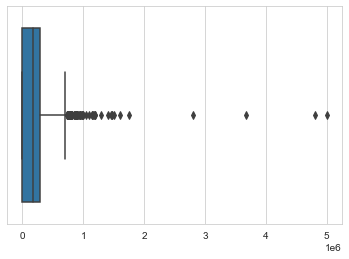

In [14]:
info = data["Price / Rent"]

prices = []
for i in info:
    pattern = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?"
    price = float(re.findall(pattern, i)[0].replace(",", ""))
    prices.append(price)

sns.boxplot(prices)

# Preprocess records

## Parking spaces

In [15]:
parkings_name = list(filter(lambda s: "parking" in s, data.columns))
parkings = data[parkings_name].copy()
parkings.head()

,RTD3307_parking1 - Parking Description,RTD3307_parking2 - Parking Description,RTD3307_parking3 - Parking Description
0,Allocated,Off Street,Residents
1,NaN,NaN,NaN
2,On Street,NaN,NaN
3,NaN,NaN,NaN
4,Driveway,Garage,Off Street


### Types of parking spaces for every property
First obtaining all the parking types in the original dataset, then get the parking types for every property

In [16]:
parkings = parkings.fillna("None")
types, counts = np.unique(parkings.to_numpy().flatten(), return_counts=True)
list(zip(types, counts))

[('Allocated', 343),
 ('Communal', 81),
 ('Covered', 36),
 ('Driveway', 1257),
 ('Garage', 842),
 ('Gated', 89),
 ('None', 6187),
 ('Off Street', 1209),
 ('On Street', 458),
 ('Permit', 70),
 ('Private', 258),
 ('Rear', 27),
 ('Residents', 90)]

In [17]:
def get_parking_spaces_for_property(first: str, second: str, third: str):
    parking_types = {"Allocated": 0, "Off Street": 0, "Residents": 0, "On Street": 0, "Driveway": 0, "Garage": 0,
                     "Permit": 0, "Private": 0, "Gated": 0, "Covered": 0, "Communal": 0, "Rear": 0}

    if first in parking_types.keys():
        parking_types[first] += 1
    if second in parking_types.keys():
        parking_types[second] += 1
    if third in parking_types.keys():
        parking_types[third] += 1

    return parking_types

In [18]:
parking_types = {key: [] for key in types if key != "None"}
for i in range(len(parkings)):
    first = parkings.iloc[i, 0]
    second = parkings.iloc[i, 1]
    third = parkings.iloc[i, 2]
    types = get_parking_spaces_for_property(first, second, third)

    list(map(lambda value, d: parking_types[d].append(types[value]), types.keys(), types.keys()))

In [19]:
for k, v in parking_types.items():
    print("{:10s}\t{:5d}".format(k, sum(v)))

Allocated 	  343
Communal  	   81
Covered   	   36
Driveway  	 1257
Garage    	  842
Gated     	   89
Off Street	 1209
On Street 	  458
Permit    	   70
Private   	  258
Rear      	   27
Residents 	   90


### Number of parking spaces for every property

In [20]:
parkings = data[parkings_name]
parking_num = [parkings.iloc[i].count() for i in range(len(parkings))]
parking_num = pd.DataFrame({"parking num": parking_num})
parking_num.head()

,parking num
0,3
1,0
2,1
3,0
4,3


In [21]:
parking_num.sum()

parking num    4760
dtype: int64

## Outside spaces

In [22]:
outside_name = list(filter(lambda s: "outside_space" in s, data.columns))
outside = data[outside_name].copy()
outside.head()

,RTD3308_outside_space1 - Outside Space Description,RTD3308_outside_space2 - Outside Space Description,RTD3308_outside_space3 - Outside Space Description
0,Communal Garden,NaN,NaN
1,NaN,NaN,NaN
2,Rear Garden,Private Garden,NaN
3,NaN,NaN,NaN
4,Back Garden,Enclosed Garden,Private Garden


### Types of outside spaces for every property

In [23]:
def record_types(first: str, second: str, third: str, types: dict):
    if first in types.keys():
        types[first] += 1
    if second in types.keys():
        types[second] += 1
    if third in types.keys():
        types[third] += 1

    return types

In [24]:
outside = outside.fillna("None")
types, counts = np.unique(outside.to_numpy().flatten(), return_counts=True)
list(zip(types, counts))

[('Back Garden', 1366),
 ('Communal Garden', 227),
 ('Enclosed Garden', 735),
 ('Front Garden', 682),
 ('None', 6012),
 ('Patio', 431),
 ('Private Garden', 599),
 ('Rear Garden', 802),
 ('Terrace', 93)]

In [25]:
outside_types = {key: [] for key in types if key != "None"}
for i in range(len(outside)):
    types = {key: 0 for key in types if key != "None"}
    first = outside.iloc[i, 0]
    second = outside.iloc[i, 1]
    third = outside.iloc[i, 2]
    types = record_types(first, second, third, types)

    list(map(lambda value, d: outside_types[d].append(types[value]), types.keys(), types.keys()))

In [26]:
for k, v in outside_types.items():
    print("{:15s}{:5d}".format(k, sum(v)))

Back Garden     1366
Communal Garden  227
Enclosed Garden  735
Front Garden     682
Patio            431
Private Garden   599
Rear Garden      802
Terrace           93


### Number of outside spaces for every property

In [27]:
outside = data[outside_name]
outside_num = [outside.iloc[i].count() for i in range(len(outside))]
temp = pd.DataFrame({"outside_num": outside_num})
temp.head()

,outside_num
0,1
1,0
2,2
3,0
4,3


## Condition

In [29]:
condition_names = list(filter(lambda s: "condition" in s, data.columns))
condition = data[condition_names].copy()
condition.head()

,RTD3316_condition1 - Condition Description
0,Good
1,NaN
2,Good
3,NaN
4,Good


In [30]:
condition = condition.fillna("None")
condition.head()

,RTD3316_condition1 - Condition Description
0,Good
1,None
2,Good
3,None
4,Good


## Heating

In [31]:
heating_names = list(filter(lambda s: "heating" in s, data.columns))
heating = data[heating_names].copy()
heating.head()

,RTD3318_heating1 - Heating Description,RTD3318_heating2 - Heating Description,RTD3318_heating3 - Heating Description
0,Double Glazing,Electric,Night Storage
1,NaN,NaN,NaN
2,Central,Gas Central,Double Glazing
3,NaN,NaN,NaN
4,Central,Gas,Double Glazing


In [32]:
heating = heating.fillna("None")
types, count = np.unique(heating.to_numpy().flatten(), return_counts=True)
list(zip(types, count))

[('Air Conditioning', 6),
 ('Central', 476),
 ('Double Glazing', 1550),
 ('Eco-Friendly', 17),
 ('Electric', 183),
 ('Gas', 493),
 ('Gas Central', 1814),
 ('Night Storage', 24),
 ('None', 6270),
 ('Oil', 63),
 ('Solar', 15),
 ('Solar Water', 2),
 ('Under Floor', 34)]

### Types of heating for every property

In [33]:
heating_types = {key: [] for key in types if key != "None"}
for i in range(len(heating)):
    types = {key: 0 for key in types if key != "None"}

    first = heating.iloc[i, 0]
    second = heating.iloc[i, 1]
    third = heating.iloc[i, 2]
    types = record_types(first, second, third, types)

    list(map(lambda d: heating_types[d].append(types[d]), types.keys()))

In [34]:
for k, v in heating_types.items():
    print("{:20s}{:5d}".format(k, sum(v)))

Air Conditioning        6
Central               476
Double Glazing       1550
Eco-Friendly           17
Electric              183
Gas                   493
Gas Central          1814
Night Storage          24
Oil                    63
Solar                  15
Solar Water             2
Under Floor            34


### Number of heating

In [35]:
heating = data[heating_names]
heating_num = [heating.iloc[i].count() for i in range(len(heating))]
temp = pd.DataFrame({"heating_num": heating_num})
temp.head()

,heating_num
0,3
1,0
2,3
3,0
4,3


In [36]:
temp.sum()

heating_num    4677
dtype: int64

## Accessibility

In [37]:
accessibility_name = list(filter(lambda s: "accessibility" in s, data.columns))
accessibility = data[accessibility_name].copy()
accessibility.head()

,RTD3317_accessibility1 - accessibility Description,RTD3317_accessibility2 - accessibility Description,RTD3317_accessibility3 - accessibility Description
0,Not suitable for wheelchair users,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,Level access,NaN,NaN


In [38]:
accessibility = accessibility.fillna("None")
types, count = np.unique(accessibility.to_numpy().flatten(), return_counts=True)

### Types of accessibility

In [39]:
accessibility_type = {key: [] for key in types if key != "None"}
for i in range(len(accessibility)):
    types = {key: 0 for key in types if key != "None"}

    first = accessibility.iloc[i, 0]
    second = accessibility.iloc[i, 1]
    third = accessibility.iloc[i, 2]
    types = record_types(first, second, third, types)

    list(map(lambda d: accessibility_type[d].append(types[d]), types.keys()))

In [40]:
for k, v in accessibility_type.items():
    print("{:35s}{:5d}".format(k, sum(v)))

Level access                         522
Lift access                           64
Not suitable for wheelchair users    779
Ramped access                         24
Wet room                              19
Wide doorways                         47


### Number of accessibility

In [41]:
accessibility = data[accessibility_name]
accessibility_num = [accessibility.iloc[i].count() for i in range(len(accessibility))]
temp = pd.DataFrame({"accessibility_num": accessibility_num})
temp

,accessibility_num
0,1
1,0
2,0
3,0
4,1
...,...
3644,0
3645,0
3646,0
3647,0


## Rooms

In [42]:
extract_area = parse.compile("{} ({} sqm){}")

### Bedrooms

In [43]:
info = data["EweMove Description S3 Rooms"]
handler = ProcessHTML()
for i in info:
    handler.EweMove_Description_S3_Rooms(i)

In [44]:
bedroom_names = [i for i in handler.s3_rooms_set if "Bedroom" in i]
bedroom_names

['Bedroom67',
 'Bedroom (Double)65',
 'Bedroom (Single)64',
 'Bedroom/Living Room',
 'Bedroom86',
 'Bedroom89',
 'Bedroom 139',
 'Bedroom 3',
 'Bedroom (Double)99',
 'Bedroom88',
 'Bedroom (Single)70',
 'Bedroom82',
 'Bedroom71',
 'Bedroom (Double) with Ensuite25',
 'Bedroom (Double)17',
 'Master Bedroom36',
 'Bedroom75',
 'Bedroom (Double)85',
 'Bedroom 263',
 'Bedroom (Single)46',
 'Bedroom87',
 'Bedroom70',
 'Bedroom (Double)51',
 'Bedroom (Double)8',
 'Bedroom74',
 'Bedroom37',
 'Bedroom18',
 'Bedroom44',
 'Bedroom76',
 'Bedroom 225',
 'Bedroom (Double)15',
 'Bedroom (Double)43',
 'Bedroom (Double)56',
 'Bedroom (Double)73',
 'Bedroom (Double) with Ensuite66',
 'Bedroom (Double)89',
 'Bedroom (Double) with Ensuite89',
 'Bedroom (Double) with Ensuite70',
 'Bedroom69',
 'Bedroom (Single)43',
 'Bedroom (Double)88',
 'Bedroom (Double)80',
 'Bedroom52',
 'Bedroom (Double)9',
 'Bedroom (Single)65',
 'Bedroom23',
 'Bedroom (Double)72',
 'Bedroom (Double)6',
 'Bedroom95',
 'Bedroom3',
 'Be

In [45]:
for room in handler.s3_rooms[: 5]:
    if room is None: continue
    for k, v in room.items():
        if k in bedroom_names:
            print("{:30s}{}".format(k, v))

Bedroom 1                     3.37m x 2.45m (8.2 sqm) - 11' x 8' (88 sqft)
Bedroom 2                     2.54m x 2.45m (6.2 sqm) - 8' 4" x 8' (67 sqft)
Bedroom 1                     4.07m x 2.43m (9.8 sqm) - 13' 4" x 7' 11" (106 sqft)
Bedroom 2                     3.48m x 2.43m (8.4 sqm) - 11' 5" x 7' 11" (91 sqft)
Bedroom 3                     5.74m x 2.31m (13.2 sqm) - 18' 9" x 7' 6" (142 sqft)
Bedroom 4                     5.34m x 3.13m (16.7 sqm) - 17' 6" x 10' 3" (179 sqft)
Bedroom (Double)              4.05m x 3.25m (13.1 sqm) - 13' 3" x 10' 7" (142 sqft)
Bedroom (Double)3             3.28m x 2.36m (7.7 sqm) - 10' 9" x 7' 8" (83 sqft)
Bedroom (Double)96            4.3m x 2.44m (10.4 sqm) - 14' 1" x 8' (112 sqft)
Master Bedroom                4.83m x 2.29m (11 sqm) - 15' 10" x 7' 6" (119 sqft)
Bedroom 2                     3.24m x 3.01m (9.7 sqm) - 10' 7" x 9' 10" (104 sqft)
Bedroom 3                     2.86m x 2.62m (7.4 sqm) - 9' 4" x 8' 7" (80 sqft)
Bedroom 4                  

#### Obtain the maximum number of bedrooms in a property

In [46]:
bedrooms_num = []
for room in handler.s3_rooms:
    if room is None:
        bedrooms_num.append(0)
        continue

    bedrooms_num.append(len([key for key in room.keys() if "Bedroom" in key]))
max_bedroom_num = max(bedrooms_num)

#### Bedroom area

In [47]:
bedroom_names = ["Bedroom {}".format(i + 1) for i in range(max_bedroom_num)]
bedrooms = []
for i in range(len(handler.s3_rooms)):
    bedroom_per_property = {key: 0 for key in bedroom_names}
    if handler.s3_rooms[i] is None:
        bedrooms.append(bedroom_per_property)
        continue

    num = 1
    for k, v in handler.s3_rooms[i].items():
        if "Bedroom" not in k:
            continue

        if not isinstance(v, str):
            bedroom_per_property["Bedroom {}".format(num)] = 0
            num += 1
            continue

        bedroom_per_property["Bedroom {}".format(num)] = float(extract_area.parse(handler.s3_rooms[i][k])[1])
        num += 1

    bedrooms.append(bedroom_per_property)

In [48]:
bedrooms = pd.DataFrame(bedrooms)
bedrooms.head()

,Bedroom 1,Bedroom 2,Bedroom 3,Bedroom 4,Bedroom 5,Bedroom 6,Bedroom 7,Bedroom 8,Bedroom 9,Bedroom 10,Bedroom 11
0,8.2,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.8,8.4,13.2,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.1,7.7,10.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.0,9.7,7.4,7.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Kitchen

In [49]:
for room in handler.s3_rooms[: 50]:
    if room is None: continue
    for k, v in room.items():
        if "kitchen" in k.lower():
            print("{:30s}{}".format(k, v))

Kitchen                       2.68m x 2.14m (5.7 sqm) - 8' 9" x 7' (61 sqft)
Kitchen /  Dining Room        5.33m x 4.58m (24.4 sqm) - 17' 5" x 15' (262 sqft)
Kitchen                       2.97m x 2.36m (7 sqm) - 9' 8" x 7' 8" (75 sqft)
Kitchen                       3.99m x 2.61m (10.4 sqm) - 13' 1" x 8' 6" (112 sqft)
Kitchen                       4.2m x 3.5m (14.7 sqm) - 13' 9" x 11' 5" (158 sqft)
Kitchen                       3.12m x 2.83m (8.8 sqm) - 10' 2" x 9' 3" (95 sqft)
Kitchen /  Dining Room        4.5m x 3.7m (16.6 sqm) - 14' 9" x 12' 1" (179 sqft)
Kitchen Diner                 4.76m x 2.78m (13.2 sqm) - 15' 7" x 9' 1" (142 sqft)
Kitchen /  Dining Room        2.82m x 4.46m (12.5 sqm) - 9' 3" x 14' 7" (135 sqft)
Kitchen                       1
Kitchen                       7.49m x 3.1m (23.2 sqm) - 24' 6" x 10' 2" (249 sqft)
Kitchen /  Dining Room        6.5m x 3.73m (24.2 sqm) - 21' 3" x 12' 2" (260 sqft)
Kitchen                       3.3m x 3m (9.9 sqm) - 10' 9" x 9' 10" (106

In [50]:
kitchens = []

for i in range(len(handler.s3_rooms)):
    kitchen_per_property = 0
    if handler.s3_rooms[i] is None:
        kitchens.append(kitchen_per_property)
        continue

    for k, v in handler.s3_rooms[i].items():
        if "kitchen" in k.lower():
            kitchen_per_property = 1
            break

    kitchens.append(kitchen_per_property)

In [51]:
kitchens = pd.DataFrame({"Kitchen": kitchens})
kitchens.head()

,Kitchen
0,1
1,1
2,1
3,0
4,1


### Living/Reception

In [52]:
living_room_names = [i for i in handler.s3_rooms_set if ("living" in i.lower() or "reception" in i.lower()) and "kitchen" not in i.lower()]
for room in handler.s3_rooms[: 50]:
    if room is None: continue
    for k, v in room.items():
        if k in living_room_names:
            print("{:30s}{}".format(k, v))

Living/Dining Room            6.58m x 3.78m (24.8 sqm) - 21' 7" x 12' 4" (267 sqft)
Living Room                   4.34m x 4.11m (17.8 sqm) - 14' 3" x 13' 5" (192 sqft)
Living Room                   4.9m x 3.7m (18.1 sqm) - 16' x 12' 1" (195 sqft)
Living Room                   4.16m x 8.69m (36.1 sqm) - 13' 7" x 28' 6" (389 sqft)
Living Room                   4.5m x 3.7m (16.6 sqm) - 14' 9" x 12' 1" (179 sqft)
Living Room                   3.83m x 3.58m (13.7 sqm) - 12' 6" x 11' 8" (147 sqft)
Reception Room                3.68m x 3.68m (13.5 sqm) - 12' x 12' (145 sqft)
Living Room                   3.63m x 4.25m (15.4 sqm) - 11' 10" x 13' 11" (166 sqft)
Living Room                   3m x 4.12m (12.3 sqm) - 9' 10" x 13' 6" (133 sqft)
Living Room                   3.6m x 3.73m (13.4 sqm) - 11' 9" x 12' 2" (144 sqft)


In [53]:
receptions = []
for i in range(len(handler.s3_rooms)):
    reception_per_property = 0
    if handler.s3_rooms[i] is None:
        receptions.append(reception_per_property)
        continue

    for k, v in handler.s3_rooms[i].items():
        if k in living_room_names and isinstance(v, str):
            reception_per_property += float(extract_area.parse(handler.s3_rooms[i][k])[1])

    receptions.append(reception_per_property)

In [54]:
receptions = pd.DataFrame({"Reception": receptions})
receptions.head()

,Reception
0,24.8
1,0.0
2,0.0
3,0.0
4,0.0


### Bathroom/WC/Washroom

In [55]:
bathroom_names = [i for i in handler.s3_rooms_set if "bathroom" in i.lower() or "wc" in i.lower()]
for room in handler.s3_rooms[: 50]:
    if room is None: continue
    for k, v in room.items():
        if k in bathroom_names:
            print("{:30s}{}".format(k, v))

Bathroom                      2.14m x 2.04m (4.3 sqm) - 7' x 6' 8" (46 sqft)
Bathroom                      1.98m x 2.37m (4.6 sqm) - 6' 5" x 7' 9" (50 sqft)
Bathroom                      1
Bathroom31                    1
Family Bathroom               1
Bathroom                      2.5m x 1.7m (4.2 sqm) - 8' 2" x 5' 6" (45 sqft)
WC                            1.7m x 1.5m (2.5 sqm) - 5' 6" x 4' 11" (27 sqft)
Bathroom                      1
Bathroom                      2.24m x 1.89m (4.2 sqm) - 7' 4" x 6' 2" (45 sqft)
Bathroom                      2.08m x 1.81m (3.7 sqm) - 6' 9" x 5' 11" (40 sqft)
Bathroom                      1
WC                            2.45m x 0.75m (1.8 sqm) - 8' x 2' 5" (19 sqft)
Family Bathroom               3.29m x 3.17m (10.4 sqm) - 10' 9" x 10' 4" (112 sqft)
Family Bathroom               2.5m x 2m (5 sqm) - 8' 2" x 6' 6" (53 sqft)
Bathroom                      2.43m x 1.67m (4 sqm) - 7' 11" x 5' 5" (43 sqft)
Bathroom                      1.5m x 2.9m (4.3 sqm)

In [56]:
bathroom_names

['Bathroom48',
 'Ensuite Bathroom70',
 'Bathroom59',
 'Bathroom11',
 'Bathroom31',
 'WC19',
 'WC17',
 'Bathroom34',
 'Guest WC',
 'Ensuite Bathroom37',
 'WC54',
 'Bathroom99',
 'WC28',
 'WC91',
 'Ensuite Bathroom51',
 'Bathroom60',
 'Bathroom94',
 'Bathroom',
 'WC75',
 'WC33',
 'Bathroom18',
 'WC92',
 'Ensuite Bathroom',
 'Bathroom4',
 'Bathroom95',
 'Bathroom13',
 'Bathroom74',
 'WC27',
 'Bathroom9',
 'Bathroom30',
 'Bathroom61',
 'Bathroom62',
 'Bathroom87',
 'Bathroom46',
 'Bathroom76',
 'WC62',
 'Ensuite Bathroom0',
 'WC',
 'Bathroom15',
 'Outside WC',
 'Master Bathroom',
 'WC4',
 'Family Bathroom',
 'Bathroom16',
 'Bathroom25',
 'WC20',
 'Bathroom89',
 'Bathroom14',
 'Bathroom67',
 'Bathroom98',
 'Guest Bathroom',
 'Bathroom100',
 'Bathroom79',
 'WC73',
 'Bathroom44',
 'Bathroom85',
 'WC47',
 'Bathroom1',
 'Ensuite Bathroom62',
 'WC23',
 'WC78',
 'Bathroom64']

In [57]:
bathrooms = []
for i in range(len(handler.s3_rooms)):
    bathroom_per_property = {key: 0 for key in bathroom_names}
    if handler.s3_rooms[i] is None:
        bathrooms.append(bathroom_per_property)
        continue

    for k, v in handler.s3_rooms[i].items():
        if k in bathroom_names and isinstance(v, str):
            bathroom_per_property[k] = float(extract_area.parse(handler.s3_rooms[i][k])[1])

    bathrooms.append(bathroom_per_property)

In [58]:
bathrooms = pd.DataFrame(bathrooms)
bathrooms.head()

,Bathroom48,Ensuite Bathroom70,Bathroom59,Bathroom11,Bathroom31,WC19,WC17,Bathroom34,Guest WC,Ensuite Bathroom37,...,Bathroom79,WC73,Bathroom44,Bathroom85,WC47,Bathroom1,Ensuite Bathroom62,WC23,WC78,Bathroom64
0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


### Dining

In [59]:
dining_names = [i for i in handler.s3_rooms_set if ("dining" in i.lower() or "breakfast" in i.lower()) and "kitchen" not in i.lower() and "living" not in i.lower()]
for room in handler.s3_rooms[: 50]:
    if room is None: continue
    for k, v in room.items():
        if k in dining_names:
            print("{:30s}{}".format(k, v))

Dining Room                   3.5m x 3m (10.5 sqm) - 11' 5" x 9' 10" (113 sqft)
Dining Room                   3.13m x 2.83m (8.8 sqm) - 10' 3" x 9' 3" (95 sqft)
Dining Room                   4.3m x 3.13m (13.4 sqm) - 14' 1" x 10' 3" (144 sqft)
Dining Room                   3.1m x 2.6m (8 sqm) - 10' 2" x 8' 6" (86 sqft)
Dining Room                   5.09m x 3.7m (18.8 sqm) - 16' 8" x 12' 1" (203 sqft)
Dining Room                   3.7m x 4.12m (15.2 sqm) - 12' 1" x 13' 6" (164 sqft)


In [60]:
dining_rooms = []
for i in range(len(handler.s3_rooms)):
    dining_room_per_property = 0
    if handler.s3_rooms[i] is None:
        dining_rooms.append(dining_room_per_property)
        continue

    for k, v in handler.s3_rooms[i].items():
        if k in dining_names and isinstance(v, str):
            dining_room_per_property += float(extract_area.parse(v)[1])

    dining_rooms.append(dining_room_per_property)

In [61]:
dining_rooms = pd.DataFrame({"Dining room": dining_rooms})
dining_rooms.iloc[:10]

,Dining room
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,10.5
6,8.8
7,0.0
8,0.0
9,0.0


### Work/study

In [62]:
work_names = [i for i in handler.s3_rooms_set if "work" in i.lower() or "study" in i.lower() or "office" in i.lower()]
for room in handler.s3_rooms[: 300]:
    if room is None: continue
    for k, v in room.items():
        if k in work_names:
            print("{:30s}{}".format(k, v))

Study                         2.27m x 1.98m (4.5 sqm) - 7' 5" x 6' 5" (48 sqft)
Garage / Office               5m x 3.1m (15.5 sqm) - 16' 4" x 10' 2" (166 sqft)
Study                         2.16m x 3.14m (6.7 sqm) - 7' 1" x 10' 3" (73 sqft)
Study Area                    2.5m x 1.85m (4.6 sqm) - 8' 2" x 6' (49 sqft)
Study                         5.7m x 2m (11.4 sqm) - 18' 8" x 6' 6" (122 sqft)
Workspace                     8.69m x 2m (17.4 sqm) - 28' 6" x 6' 6" (187 sqft)
Study                         3m x 3m (9 sqm) - 9' 10" x 9' 10" (96 sqft)
Workshop                      14m x 3.6m (50.4 sqm) - 45' 11" x 11' 9" (542 sqft)
Study/Family Room/Play Room   4m x 2.91m (11.6 sqm) - 13' 1" x 9' 6" (125 sqft)
Study                         3.47m x 2.18m (7.5 sqm) - 11' 4" x 7' 1" (81 sqft)
Workshop                      5.09m x 2.14m (10.9 sqm) - 16' 8" x 7' (117 sqft)
Study                         2.1m x 2.1m (4.4 sqm) - 6' 10" x 6' 10" (47 sqft)
Study Area                    2.8m x 2.54m (7.1

In [63]:
work_spaces = []
for room in handler.s3_rooms:
    work_per_property = 0
    if room is None:
        work_spaces.append(work_per_property)
        continue

    for k, v in room.items():
        if k in work_names and isinstance(v, str):
            work_per_property += float(extract_area.parse(v)[1])

    work_spaces.append(work_per_property)

In [64]:
work_spaces = pd.DataFrame({"work space": work_spaces})
work_spaces[:50]

,work space
0,0.0
1,0.0
2,0.0
3,0.0
4,4.5
5,0.0
6,0.0
7,15.5
8,0.0
9,0.0


### Other rooms

In [65]:
bedroom_names = set([i for i in handler.s3_rooms_set if "Bedroom" in i])
kitchen_names = set(i for i in handler.s3_rooms_set if "kitchen" in i.lower())
reception_names = set(i for i in handler.s3_rooms_set if ("living" in i.lower() or "reception" in i.lower()) and "kitchen" not in i.lower())
garden_names = set([i for i in handler.s3_rooms_set if "garden" in i.lower() or "yard" in i.lower()])
bathroom_names = set(i for i in handler.s3_rooms_set if "bathroom" in i.lower() or "wc" in i.lower() or "washroom" in i.lower())
dining_names = set(i for i in handler.s3_rooms_set if ("dining" in i.lower() or "breakfast" in i.lower()) and "kitchen" not in i.lower() and "living" not in i.lower())
work_names = set([i for i in handler.s3_rooms_set if "work" in i.lower() or "study" in i.lower() or "office" in i.lower()])
parking = set(i for i in handler.s3_rooms_set if "car" in i.lower() or "garage" in i.lower() or "driveway" in i.lower() or "park" in i.lower())

rest_names = handler.s3_rooms_set - bedroom_names - kitchen_names - reception_names - garden_names - bathroom_names - dining_names - work_names - parking

In [66]:
for room in handler.s3_rooms[:50]:
    if room is None: continue
    for k, v in room.items():
        if k in rest_names:
            print("{:30s}{}".format(k, v))

Entrance Hall                 1
Porch                         1.48m x 2.31m (3.4 sqm) - 4' 10" x 7' 6" (36 sqft)
Hallway                       5.03m x 2.77m (13.9 sqm) - 16' 6" x 9' 1" (149 sqft)
Shower Room                   0.79m x 1.57m (1.2 sqm) - 2' 7" x 5' 1" (13 sqft)
Utility Room                  1.6m x 2.76m (4.4 sqm) - 5' 2" x 9' (47 sqft)
Downstairs Cloakroom          1.68m x 1.1m (1.8 sqm) - 5' 6" x 3' 7" (19 sqft)
Landing                       2.63m x 1.04m (2.7 sqm) - 8' 7" x 3' 4" (29 sqft)
Lounge                        4.33m x 5.36m (23.2 sqm) - 14' 2" x 17' 7" (249 sqft)
Landing75                     2.41m x 1.06m (2.5 sqm) - 7' 10" x 3' 5" (27 sqft)
Entrance Porch                1
Lounge Diner                  6.76m x 4.04m (27.3 sqm) - 22' 2" x 13' 3" (293 sqft)
Lobby                         1
Landing                       1
Entrance Hall                 1
Downstairs Cloakroom          1
Lounge Diner                  6.66m x 3.1m (20.6 sqm) - 21' 10" x 10' 2" (222 sq

In [67]:
other_rooms = []
for room in handler.s3_rooms:
    other_room_per_property = 0
    if room is None:
        other_rooms.append(other_room_per_property)
        continue

    for k, v in room.items():
        if k in rest_names:
            other_room_per_property += 1
    other_rooms.append(other_room_per_property)

In [68]:
other_rooms = pd.DataFrame({"Other rooms": other_rooms})
other_rooms.head()

,Other rooms
0,1
1,8
2,4
3,0
4,5


# Testing classes

## Room information HTML texts
### Test HTML texts

In [69]:
handler = ProcessHTML()

info1 = """This home includes:
<ul>
    <li>
        <strong>01 - Entrance Hall</strong><br><br>
    </li>
    <li>
        <strong>02 - Living/Dining Room</strong><br><br>
        <i>6.58m x 3.78m (24.8 sqm) - 21' 7" x 12' 4" (267 sqft)</i><br><br>
    </li>
    <li>
        <strong>03 - Kitchen</strong><br><br>
        <i>2.68m x 2.14m (5.7 sqm) - 8' 9" x 7' (61 sqft)</i><br><br>
    </li>
    <li>
        <strong>04 - Bedroom 1</strong><br><br>
        <i>3.37m x 2.45m (8.2 sqm) - 11' x 8' (88 sqft)</i><br><br>
    </li>
    <li>
        <strong>05 - Bedroom 2</strong><br><br>
        <i>2.54m x 2.45m (6.2 sqm) - 8' 4" x 8' (67 sqft)</i><br><br>
        The second double bedroom is bright and well-sized, with room for all required furniture.<br><br>
    </li>
    <li>
        <strong>06 - Bathroom</strong><br><br>
        <i>2.14m x 2.04m (4.3 sqm) - 7' x 6' 8" (46 sqft)</i><br><br>
    </li>
    <li>
        <strong>07 - Garden</strong><br><br>
        Communal Gardens.<br><br>
    </li>
    <li>
        <strong>08 - Parking</strong><br><br>
        2 allocated parking spaces.<br><br>
    </li>
</ul>"""

handler.EweMove_Description_S3_Rooms(info1)
for k, v in handler.s3_rooms[0].items():
    print("{:20s}{}".format(k, v))

Entrance Hall       1
Living/Dining Room  6.58m x 3.78m (24.8 sqm) - 21' 7" x 12' 4" (267 sqft)
Kitchen             2.68m x 2.14m (5.7 sqm) - 8' 9" x 7' (61 sqft)
Bedroom 1           3.37m x 2.45m (8.2 sqm) - 11' x 8' (88 sqft)
Bedroom 2           2.54m x 2.45m (6.2 sqm) - 8' 4" x 8' (67 sqft)
Bathroom            2.14m x 2.04m (4.3 sqm) - 7' x 6' 8" (46 sqft)
Garden              1
Parking             1


In [70]:
info2 = """This home includes:
<ul>
    <li>
        <strong>01 - Entrance Porch</strong><br><br>
    </li>
    <li>
        <strong>02 - Lounge Diner</strong><br><br>
        <i>6.76m x 4.04m (27.3 sqm) - 22' 2" x 13' 3" (293 sqft)</i><br><br>
    </li>
    <li>
        <strong>03 - Kitchen</strong><br><br>
        <i>2.97m x 2.36m (7 sqm) - 9' 8" x 7' 8" (75 sqft)</i><br><br>
    </li>
    <li>
        <strong>05 - Bathroom</strong><br><br>
    </li>
    <li>
        <strong>07 - Bedroom (Double)</strong><br><br>
        <i>4.05m x 3.25m (13.1 sqm) - 13' 3" x 10' 7" (142 sqft)</i><br><br>
    </li>
    <li>
        <strong>08 - Bedroom (Double)</strong><br><br>
        <i>3.28m x 2.36m (7.7 sqm) - 10' 9" x 7' 8" (83 sqft)</i><br><br>
    </li>
    <li>
        <strong>09 - Bedroom (Double)</strong><br><br>
        <i>4.3m x 2.44m (10.4 sqm) - 14' 1" x 8' (112 sqft)</i><br><br>
    </li>
    <li>
        <strong>10 - Bathroom</strong><br><br>
    </li>
</ul>"""

handler.EweMove_Description_S3_Rooms(info2)
for k, v in handler.s3_rooms[1].items():
    print("{:20s}{}".format(k, v))

Entrance Porch      1
Lounge Diner        6.76m x 4.04m (27.3 sqm) - 22' 2" x 13' 3" (293 sqft)
Kitchen             2.97m x 2.36m (7 sqm) - 9' 8" x 7' 8" (75 sqft)
Bathroom            1
Bedroom (Double)    4.05m x 3.25m (13.1 sqm) - 13' 3" x 10' 7" (142 sqft)
Bedroom (Double)65  3.28m x 2.36m (7.7 sqm) - 10' 9" x 7' 8" (83 sqft)
Bedroom (Double)15  4.3m x 2.44m (10.4 sqm) - 14' 1" x 8' (112 sqft)
Bathroom56          1


### All HTML Texts

In [71]:
info = data["EweMove Description S3 Rooms"]
handler = ProcessHTML()
for i in info:
    handler.EweMove_Description_S3_Rooms(i)

In [72]:
extract_room = ExtractRooms(handler.s3_rooms, handler.s3_rooms_set, "{} ({} sqm){}")
bedrooms = extract_room.get_rooms("bedroom")

In [73]:
temp = pd.DataFrame(bedrooms)
temp.head()

,0,1,2,3,4,5,6,7,8,9
0,8.2,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.8,8.4,13.2,16.7,0.0,0.0,0.0,0.0,0.0,0.0
2,13.1,7.7,10.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.0,9.7,7.4,7.4,0.0,0.0,0.0,0.0,0.0,0.0


### General information
#### Parking

In [74]:
generalize = GeneralizeDataset(data)

In [75]:
parking = generalize.get_feature_types("parking")

In [76]:
parking = pd.DataFrame(parking)
parking.head()

,Allocated,Communal,Covered,Driveway,Garage,Gated,Off Street,On Street,Permit,Private,Rear,Residents
0,1,0,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0,0


In [77]:
parking = generalize.get_feature_num("parking")

In [78]:
parking = pd.DataFrame(parking)

In [79]:
parking.head()

,0
0,3
1,0
2,1
3,0
4,3


In [80]:
nan_num = 0
for i in range(len(parking)):
    if parking.iloc[i, 0] == 0:
        nan_num += 1

nan_num

1331

#### Outside Spaces

In [81]:
outside_space = generalize.get_feature_types("outside_space")

In [82]:
outside = pd.DataFrame(outside_space)
outside.head()

,Back Garden,Communal Garden,Enclosed Garden,Front Garden,Patio,Private Garden,Rear Garden,Terrace
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,0,0


In [83]:
outside_space = generalize.get_feature_num("outside_space")

In [84]:
outside = pd.DataFrame(outside_space)
outside.head()

,0
0,1
1,0
2,2
3,0
4,3


In [85]:
nan_num = 0
for i in range(len(outside)):
    if outside.iloc[i, 0] == 0:
        nan_num += 1

nan_num

1450

#### Heating

In [86]:
heating = generalize.get_feature_num("heating")

In [87]:
heating = pd.DataFrame(heating)

In [88]:
nan_num = 0
for i in range(len(heating)):
    if heating.iloc[i, 0] == 0:
        nan_num += 1

nan_num

1312

#### Accessibility

In [89]:
accessibility = generalize.get_feature_num("accessibility")

In [90]:
accessibility = pd.DataFrame(accessibility)

In [91]:
nan_num = 0
for i in range(len(accessibility)):
    if accessibility.iloc[i, 0] == 0:
        nan_num += 1

nan_num

2296

#### Condition

In [92]:
condition_header = [i for i in data.columns if "condition" in i.lower()]
condition = data[condition_header]

In [93]:
condition.isna().sum()

RTD3316_condition1 - Condition Description    1383
dtype: int64

In [100]:
keywords = ["car", "parking", "garage"]
info = "2 Car Parking Spaces"
line = list(map(lambda word: word in info.lower(), keywords))
line

[True, True, False]

In [101]:
description = data["EweMove Description S1 Features"]
rooms = data["EweMove Description S3 Rooms"]
for d in description:
    handler.EweMove_Description_S1_Features(d)
for r in rooms:
    handler.EweMove_Description_S3_Rooms(r)

In [111]:
index = 374
for i in handler.s1_description[index]:
    print(i)
print("\n")

if handler.s3_rooms[index] is not None:
    for k, v in handler.s3_rooms[index].items():
        print("{:30s}\t{}".format(k, v))
else:
    print("None")

Super first time buyer property!
Very well-presented with neat low maintenance garden!
Well-proportioned rooms with great lounge diner!
Cul-de-sac road with very little passing traffic
Favoured area with Excellent nearby amenities and convenient transport links
Parking: Allocated off-road parking space as well as on-road parking.


Entrance Hall                 	1
Kitchen                       	2.1m x 3m (6.3 sqm) - 6' 10" x 9' 10" (67 sqft)
Living Room                   	3.8m x 5.6m (21.2 sqm) - 12' 5" x 18' 4" (229 sqft)
First Floor Landing           	1
Bedroom 1                     	2m x 3.4m (6.8 sqm) - 6' 6" x 11' 1" (73 sqft)
Bedroom 2                     	2m x 3.4m (6.8 sqm) - 6' 6" x 11' 1" (73 sqft)
Bathroom                      	1.8m x 2.4m (4.3 sqm) - 5' 10" x 7' 10" (46 sqft)
Exterior                      	1
